<a href="https://colab.research.google.com/github/IgorWounds/Polis-Algotrading101/blob/main/Polis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polis Brexit Data

## Obtain the data and set up the libraries

In [4]:
!git clone 'https://github.com/compdemocracy/openData.git'

Cloning into 'openData'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 108 (delta 17), reused 29 (delta 6), pack-reused 49
Receiving objects: 100% (108/108), 16.97 MiB | 14.47 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [ ]:
#pip install leidenalg

In [ ]:
pip install umap-learn

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
import altair as alt
import textwrap as wrap
import umap.umap_ as umap
import igraph as ig
import leidenalg
import numba

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

## Prepare the data

In [28]:
df = pd.read_csv('/content/openData/brexit-consensus/participants-votes.csv',index_col='participant')
df_comments = pd.read_csv('/content/openData/brexit-consensus/comments.csv',index_col='comment-id')

In [29]:
df.head()

,group-id,n-comments,n-votes,n-agree,n-disagree,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
participant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,31,50,24,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0,18,8,9,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,0.0,-1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0,18,10,6,-1.0,1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0,18,8,10,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0,18,10,6,-1.0,1.0,-1.0,-1.0,0.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_comments.index = df_comments.index.astype(str)

metadata_fields = ['group-id', 'n-comments', 'n-votes', 
                   'n-agree', 'n-disagree']

val_fields = [c for c in df.columns.values if c not in metadata_fields]

# remove moderated statements
statements_all_in = sorted(list(df_comments.loc[df_comments["moderated"] > 0].index.array), key = int)

In [30]:
# count the number of finite values
def count_finite(row):
    finite = np.isfinite(row[val_fields]) 
    return sum(finite)

def select_rows(df, threshold=15):
    
    number_of_votes = df.apply(count_finite, axis=1)
    valid = number_of_votes >= threshold
    
    return df[valid]
    
df = select_rows(df)
df.head()

,group-id,n-comments,n-votes,n-agree,n-disagree,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
participant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,31,50,24,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0,18,8,9,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,0.0,-1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0,18,10,6,-1.0,1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0,18,8,10,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0,18,10,6,-1.0,1.0,-1.0,-1.0,0.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
metadata = df[metadata_fields]
vals = df[val_fields]

# Impute missing values
vals = vals.fillna(0)
vals = vals.sort_values("participant")
vals.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
participant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,0.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,1.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.0,1.0,-1.0,-1.0,0.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

Dimensions of matrix: (170, 55)
Dimensions of matrix: (170, 50)
Total number of possible votes: 8500
Total number of agrees: 2571
Total number of disagrees: 1851
Total without vote: 4078
Percent sparse:  0.4797647058823529 %


In [50]:
df_comments[['agrees','disagrees']].sort_values('agrees', ascending=False).head(10)

,agrees,disagrees
comment-id,,
14,156,4
1,155,6
17,149,8
16,144,7
13,132,11
19,122,3
11,112,39
18,92,19
25,91,11


In [51]:
consensus_agree = ["14", "1", "17", "16", "13", "19", "11","18", "25"]

In [52]:
df_comments[['agrees','disagrees']].sort_values('disagrees', ascending=False).head(10)

,agrees,disagrees
comment-id,,
0,3,162
3,4,158
5,20,131
10,45,101
2,37,100
27,1,96
23,3,95
26,1,92
12,54,88


In [103]:
consensus_disagree = ["0", "3", "5", "10", "2", "27", "23", "26"]

In [53]:
df_comments[['agrees','disagrees']].sort_values(['disagrees','agrees'], ascending=False).head(10)

,agrees,disagrees
comment-id,,
0,3,162
3,4,158
5,20,131
10,45,101
2,37,100
27,1,96
23,3,95
26,1,92
12,54,88


In [69]:
similar_df = df_comments[['agrees','disagrees']]

In [ ]:
similar_df['Result'] = abs(similar_df['agrees']-similar_df['disagrees'])
similar_df = similar_df[similar_df['Result'] < 30]
similar_df.sort_values('Result', ascending=False)

In [71]:
divisive = ["4", "29", "7", "15", "22", "9", "44", "24"]

In [81]:
vals_consensus_agree = vals[concesus_agree]
vals_consensus_disagree = vals[consensus_disagree]
vals_divisive = vals[divisive]
vals_all_in = vals[statements_all_in]

In [93]:
@numba.njit()
def sparsity_aware_dist(a, b):
    n_both_seen = len(a) - (np.isnan(a) | np.isnan(b)).sum()
    return (n_both_seen - (a == b).sum() + 1) / (n_both_seen + 2)

def polis_pca(dataframe, components):
    pca_object = PCA(n_components=components) ## pca is apparently different, it wants 
    pca_object = pca_object.fit(dataframe.T) ## .T transposes the matrix (flips it)
    coords = pca_object.components_.T ## isolate the coordinates and flip 
    explained_variance = pca_object.explained_variance_ratio_

    return coords, explained_variance

def polis_umap(dataframe, neighbors):
    reducer = umap.UMAP(
        n_neighbors=neighbors,
        metric=sparsity_aware_dist,
        init='random',
        min_dist=0.1,
        spread=1.0,
        local_connectivity=3.0,
    )
    embedding = reducer.fit_transform(dataframe.values)
    # embedding.shape
    
    return embedding

def c(comment, coords):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    colorMap = {-1:'#A50026', 1:'#313695', 0:'#FEFEC050'}
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=vals[str(comment)].apply(lambda x: colorMap[x]),
        s=10
    )
    ax.set_title("\n".join(wrap(str(comment) + "  " + str(df_comments['comment-body'][comment]))), fontsize=14)
    plt.show()

## Thanks to https://github.com/ciortanmadalina/high_noise_clustering/blob/master/graph-partitioning-louvain.ipynb

def polis_leiden(dataframe, neighbors):
    A = kneighbors_graph(
        dataframe.values, 
        neighbors, 
        mode="connectivity", 
        metric=sparsity_aware_dist, 
        p=3, 
        metric_params=None, 
        include_self=True, 
        n_jobs=None
    )

    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix): # ravel data
            weights = weights.A1

    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])  # each observation is a node
    edges = list(zip(sources, targets))
    g.add_edges(edges)
    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)

    part = leidenalg.find_partition(
        g, 
        leidenalg.ModularityVertexPartition
    );

    leidenClusters = np.array(part.membership)
    leidenClustersStr = [str(i) for i in leidenClusters] 

    #df["leiden"] = leidenClustersStr
    
    return leidenClusters

In [94]:
def polis_subconversation(dataframe, comments):
    coords, explained_variance = polis_pca(dataframe, 2)
    print("Explained variance:", explained_variance)

    embedding = polis_umap(dataframe, 10)

    leidenClusters = polis_leiden(dataframe, 8)


    # Show clusters given umap embedding 
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=embedding[:,0],
        y=embedding[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )
    ax.set_title("Leiden detected communities in UMAP space", fontsize=14)


    # Show clusters given pca embedding 
    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    ax.scatter(
        x=coords[:,0],
        y=coords[:,1],
        c=leidenClusters,
        cmap="tab20",
        s=5
    )

    ax.set_title("Leiden detected communities in PCA space", fontsize=14)
    plt.show()
    
    # number of votes in pca space
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0], 
        y=coords[:,1], 
        c=metadata['n-votes'],
        cmap="magma_r",
        s=5
    )
    plt.colorbar()
    
    # when did the participant show up? index
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0], 
        y=coords[:,1], 
        c=metadata.index,
        cmap="magma_r",
        s=5
    )
    plt.colorbar()
    
    
    # PCA for COMMENTS
    
    coords, explained_variance = polis_pca(dataframe.T, 2)
    
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=coords[:,0], 
        y=coords[:,1], 
#         c=,
        cmap="magma_r",
        s=5
    )
    
    

#     plt.colorbar()
    
#     # Show clustermap
#     dataframe['leiden_cluster_assignments'] = leidenClusters
#     clusters_by_comments_means = dataframe.groupby('leiden_cluster_assignments').agg('mean')

#     #sns.heatmap(clusters_by_comments_means, cmap="RdYlBu")
#     sns.clustermap(clusters_by_comments_means, cmap="RdYlBu", figsize=(15,15))

    for x in comments:
        c(x, coords)
        c(x, embedding)


In [91]:
def polis_heatmap(__dataframe):
    leidenClusters = polis_leiden(__dataframe, 8)

    # Show clustermap
    __dataframe['leiden_cluster_assignments'] = leidenClusters
    clusters_by_comments_means = __dataframe.groupby('leiden_cluster_assignments').agg('mean').T

    index_to_label = df_comments['comment-body'].to_dict() # {index: label}

    clustergrid = sns.clustermap(clusters_by_comments_means, cmap="RdBu", figsize=(10,10), )

    ax = clustergrid.ax_heatmap
    new_labels = [index_to_label[str(idx._text)] for idx in ax.get_yticklabels()] # [ label0, label1, label2, ...]
    ax.set_yticklabels(new_labels, rotation=0, fontsize=10)

In [ ]:
coords, embedding = polis_pca(vals_all_in, 2)

plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
    x=coords[:,0], 
    y=coords[:,1], 
    c=metadata['n-votes'],
    cmap="rainbow",
    s=5
)
plt.colorbar()

In [ ]:
#polis_subconversation(vals_all_in, concesus_agree)

In [ ]:
#polis_subconversation(vals_all_in, consensus_disagree)

In [ ]:
#polis_subconversation(vals_all_in, divisive)

[Text(0.5, 0, "(44, 'A second referendum would be pointless as it would be run on the same lines as the first and majority of people will be no better informed.')"),
 Text(1.5, 0, "(29, 'There should not be a second referendum on the original question')"),
 Text(2.5, 0, "(24, 'A Pro-EU centrist party could have done better, but the Lib Dems were poisoned by their association with Tory Austerity.')"),
 Text(3.5, 0, "(22, 'Whatever happens, the UK is better off out of the Euro.')"),
 Text(4.5, 0, "(15, 'I can speak a European language.')"),
 Text(5.5, 0, '(9, "Labour should listen to the genuine concerns of leave voters and not just try to override a referendum because they don\'t like the results.")'),
 Text(6.5, 0, "(7, 'Labour was right to support the article 50 vote.')"),
 Text(7.5, 0, "(4, 'Brexit could be a success, but not let by this incompetent Tory party.')")]

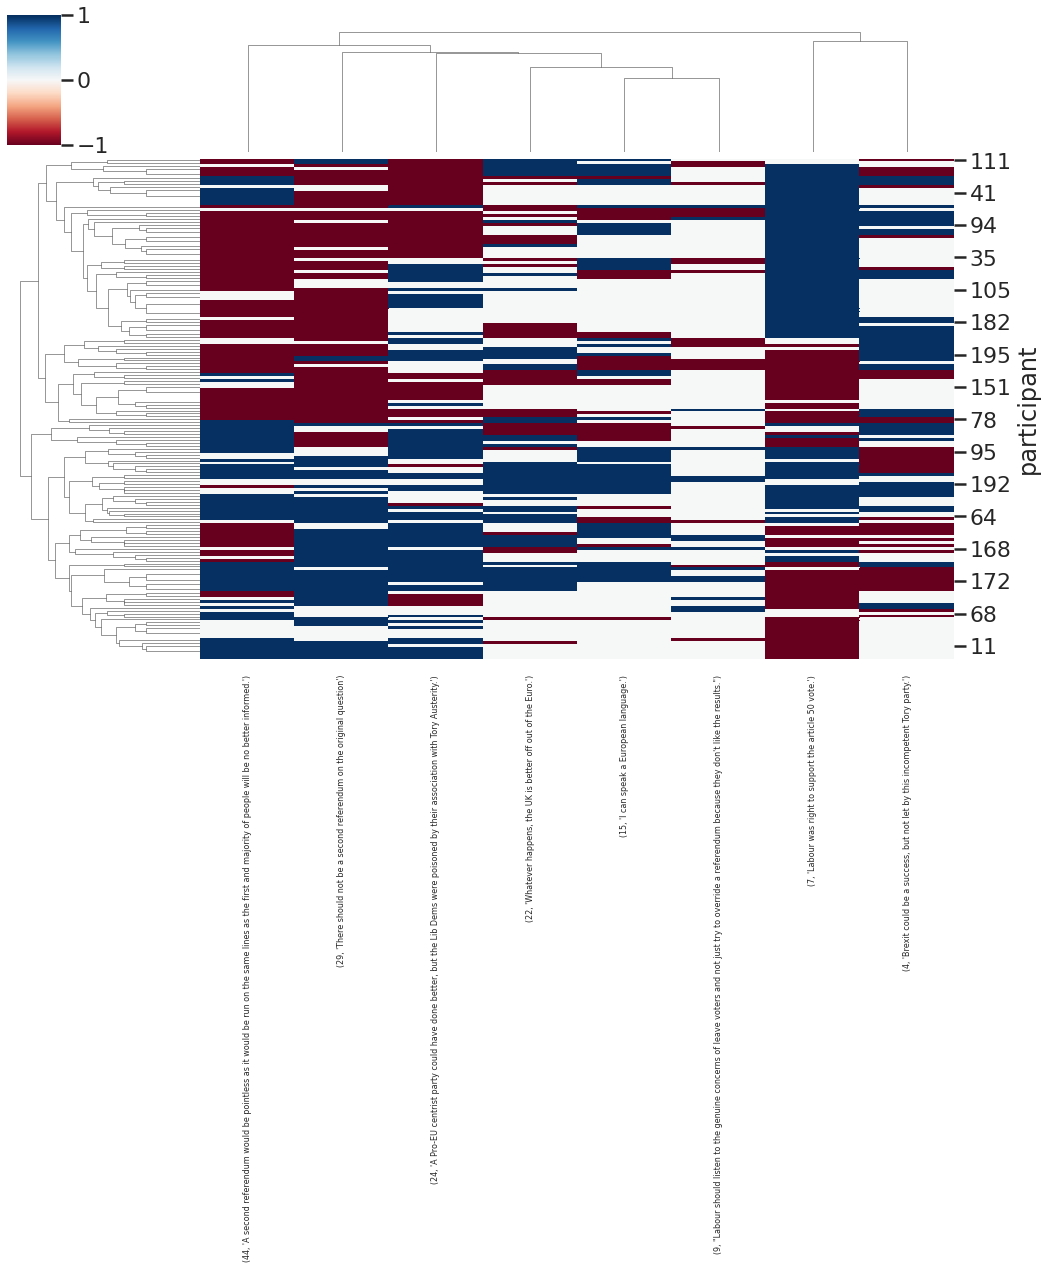

In [172]:
index_to_label = df_comments['comment-body'].to_dict() # {index: label}

clustergrid = sns.clustermap(vals_divisive, cmap="RdBu", figsize=(15,10), )
ax = clustergrid.ax_heatmap

new_labels = [str(idx._text) for idx in ax.get_xticklabels()]
new_labels = list(map(int, new_labels))

dict_filter = lambda x, y: dict([(i,x[i]) for i in x if i in set(y)])

new = dict_filter(index_to_label, new_labels)

ax.set_xticklabels(new.items(), rotation=90, fontsize=8)